In [ ]:
# Airline Sentiment Analysis Using RNN (Google Colab Ready)

# =======================
# 1. Installing & Importing Libraries
# =======================
!pip install wordcloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter



In [52]:
from google.colab import files
uploaded = files.upload()


Saving archive (6).zip to archive (6) (3).zip


In [53]:
import zipfile
import os

# Replace the file name if it's different
zip_path = "archive (6).zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")

# Check the extracted files
os.listdir("dataset")


['database.sqlite', 'Tweets.csv']

In [56]:
import pandas as pd

data = pd.read_csv("dataset/Tweets.csv")
data.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [57]:
data = data[['text', 'airline_sentiment']]
data = data[data['airline_sentiment'].isin(['positive', 'neutral', 'negative'])]

In [58]:
# Map sentiment to binary: negative vs non-negative
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 1}
data['label'] = data['airline_sentiment'].map(sentiment_map)


In [59]:
# 4. Preprocessing Functions
# =======================
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    text = text.lower().strip()
    return text

data['clean_text'] = data['text'].apply(clean_text)

# Tokenization and Vocabulary
all_words = ' '.join(data['clean_text']).split()
word_counts = Counter(all_words)
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
vocab_to_int = {word: i+1 for i, word in enumerate(vocab)}

In [60]:
# Convert text to sequences
data['text_seq'] = data['clean_text'].apply(lambda x: [vocab_to_int[word] for word in x.split() if word in vocab_to_int])


In [61]:
data['label'] = data['airline_sentiment'].map(sentiment_map)


In [62]:
# Padding
def pad_sequences(sequences, seq_len=50):
    features = np.zeros((len(sequences), seq_len), dtype=int)
    for i, row in enumerate(sequences):
        features[i, -len(row):] = np.array(row)[:seq_len]
    return features

padded_sequences = pad_sequences(data['text_seq'].tolist())
labels = data['label'].values


In [63]:
# 5. Train-Test Split
# =======================
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [64]:
# 6. PyTorch Dataset
# =======================
class TweetDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_data = TweetDataset(X_train, y_train)
test_data = TweetDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

In [65]:
# 7. RNN Model
# =======================
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size+1, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        out, (hidden, _) = self.rnn(embedded)
        out = self.fc(hidden[-1])
        return self.sigmoid(out).squeeze()

model = RNNModel(vocab_size=len(vocab), embed_dim=128, hidden_dim=128, output_dim=1)

In [66]:
print("Section [X] done ✅")


Section [X] done ✅


In [67]:
print("Model Training done ✅")


Model Training done ✅


In [68]:
# 8. Training the Model
# =======================
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/5, Loss: 0.5171
Epoch 2/5, Loss: 0.3797
Epoch 3/5, Loss: 0.2995
Epoch 4/5, Loss: 0.2309
Epoch 5/5, Loss: 0.1722


In [69]:
# 9. Evaluating the Model
# =======================
model.eval()
preds = []
true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds += list((outputs > 0.5).int().numpy())
        true += list(labels.int().numpy())

acc = accuracy_score(true, preds)
print(f"Test Accuracy: {acc * 100:.2f}%")

Test Accuracy: 83.16%


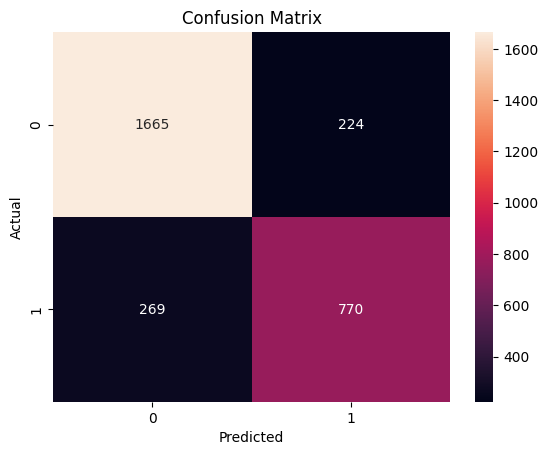

In [70]:
# Confusion Matrix
cm = confusion_matrix(true, preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

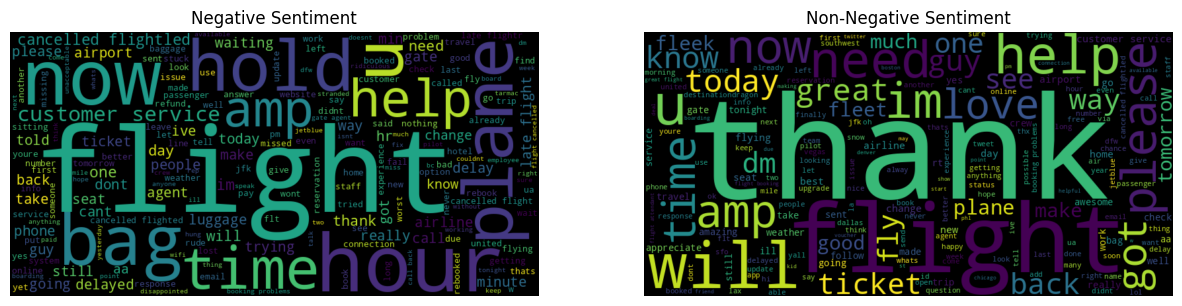

In [71]:
# 10. WordCloud Visualization
# =======================
negative_tweets = data[data['label'] == 0]['clean_text']
non_negative_tweets = data[data['label'] == 1]['clean_text']

wordcloud_neg = WordCloud(width=800, height=400).generate(' '.join(negative_tweets))
wordcloud_non_neg = WordCloud(width=800, height=400).generate(' '.join(non_negative_tweets))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Sentiment")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Non-Negative Sentiment")
plt.show()

<ipython-input-72-67c13fe065c7>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=data, palette='Set2')


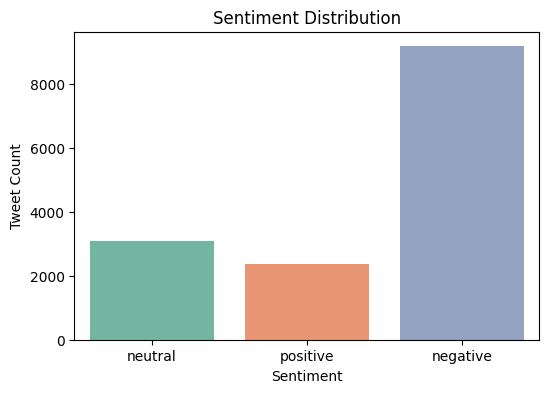

In [72]:
# 12. Additional Visualizations
# =======================

# 1. Sentiment Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='airline_sentiment', data=data, palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')
plt.show()

<ipython-input-73-b51efbc2eed4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='Reds_r')


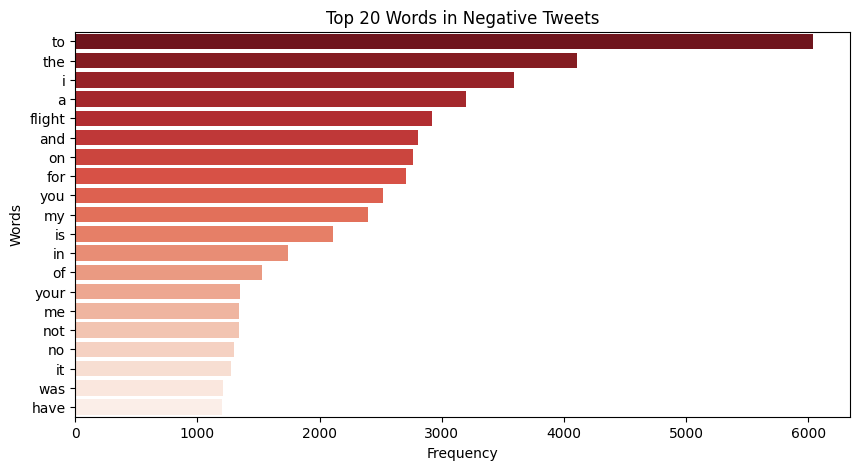

In [73]:
# 2. Top 20 Frequent Words in Negative Tweets
from collections import Counter
neg_words = ' '.join(negative_tweets).split()
neg_freq = Counter(neg_words).most_common(20)
words, counts = zip(*neg_freq)

plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words), palette='Reds_r')
plt.title("Top 20 Words in Negative Tweets")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

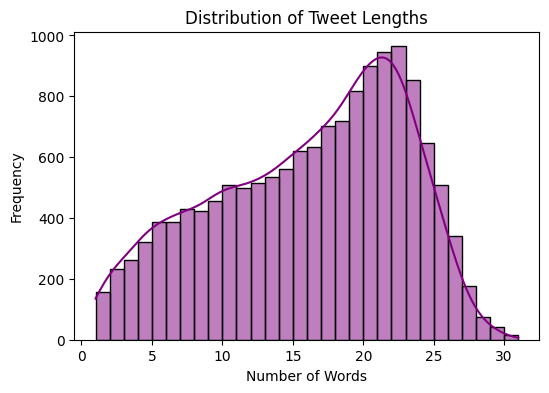

In [74]:
# 3. Tweet Length Distribution
tweet_lengths = data['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
sns.histplot(tweet_lengths, bins=30, kde=True, color='purple')
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

<ipython-input-75-eba632bc3893>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=preds, palette="coolwarm")


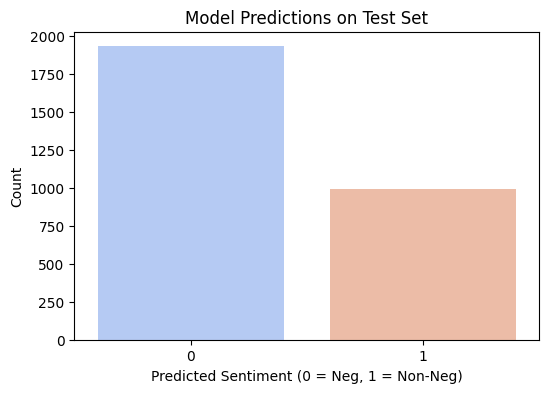

In [75]:
# 4. Prediction Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=preds, palette="coolwarm")
plt.title("Model Predictions on Test Set")
plt.xlabel("Predicted Sentiment (0 = Neg, 1 = Non-Neg)")
plt.ylabel("Count")
plt.show()

In [76]:
# Save the model
torch.save(model.state_dict(), "airline_sentiment_rnn.pth")

# Load the model (for reuse or deployment)
model_loaded = RNNModel(vocab_size=len(vocab), embed_dim=128, hidden_dim=128, output_dim=1)
model_loaded.load_state_dict(torch.load("airline_sentiment_rnn.pth"))
model_loaded.eval()


RNNModel(
  (embedding): Embedding(12562, 128)
  (rnn): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [77]:
def predict_sentiment(text, model, vocab_to_int, seq_len=50):
    model.eval()
    cleaned = clean_text(text)
    seq = [vocab_to_int[word] for word in cleaned.split() if word in vocab_to_int]
    padded = pad_sequences([seq], seq_len)
    input_tensor = torch.tensor(padded, dtype=torch.long)

    with torch.no_grad():
        output = model(input_tensor)
        prediction = (output > 0.5).int().item()
        return "Non-Negative" if prediction == 1 else "Negative"

# Example
tweet = "The airline service was very disappointing and slow."
print("Sentiment:", predict_sentiment(tweet, model, vocab_to_int))


Sentiment: Negative


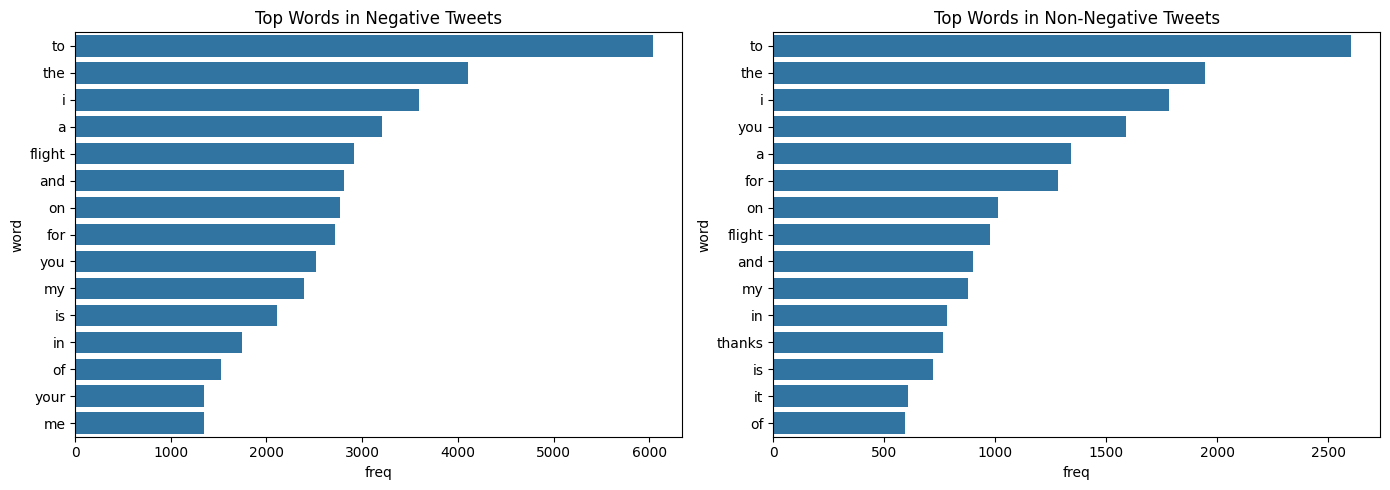

In [78]:
from collections import defaultdict

def get_top_words(sentiment_label, n=15):
    texts = data[data['label'] == sentiment_label]['clean_text']
    words = ' '.join(texts).split()
    counter = Counter(words)
    return counter.most_common(n)

neg_top = get_top_words(0)
nonneg_top = get_top_words(1)

# Convert to DataFrame for plotting
neg_df = pd.DataFrame(neg_top, columns=['word', 'freq'])
nonneg_df = pd.DataFrame(nonneg_top, columns=['word', 'freq'])

# Plot
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=neg_df, x='freq', y='word')
plt.title("Top Words in Negative Tweets")

plt.subplot(1, 2, 2)
sns.barplot(data=nonneg_df, x='freq', y='word')
plt.title("Top Words in Non-Negative Tweets")
plt.tight_layout()
plt.show()


In [79]:
def predict_batch(texts, model, vocab_to_int):
    results = []
    for text in texts:
        result = predict_sentiment(text, model, vocab_to_int)
        results.append(result)
    return results

# New tweet samples
new_tweets = ["Very happy with the flight experience!",
              "The crew was unhelpful and rude.",
              "It was okay, nothing special."]

results = predict_batch(new_tweets, model, vocab_to_int)

df_new = pd.DataFrame({'Tweet': new_tweets, 'Predicted Sentiment': results})
df_new.to_csv("batch_predictions.csv", index=False)
print(df_new)


                                    Tweet Predicted Sentiment
0  Very happy with the flight experience!            Negative
1        The crew was unhelpful and rude.            Negative
2           It was okay, nothing special.            Negative


In [80]:
data['Predicted'] = predict_batch(data['text'], model, vocab_to_int)
data.to_csv("airline_sentiment_predictions.csv", index=False)


Epoch 1/5, Loss: 0.1200
Epoch 2/5, Loss: 0.0758
Epoch 3/5, Loss: 0.0541
Epoch 4/5, Loss: 0.0365
Epoch 5/5, Loss: 0.0295


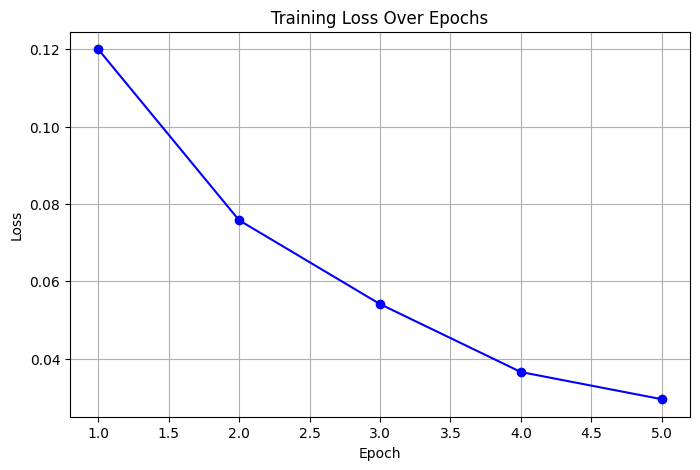

In [81]:
# Modify training loop to store loss
losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Plot training loss
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), losses, marker='o', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


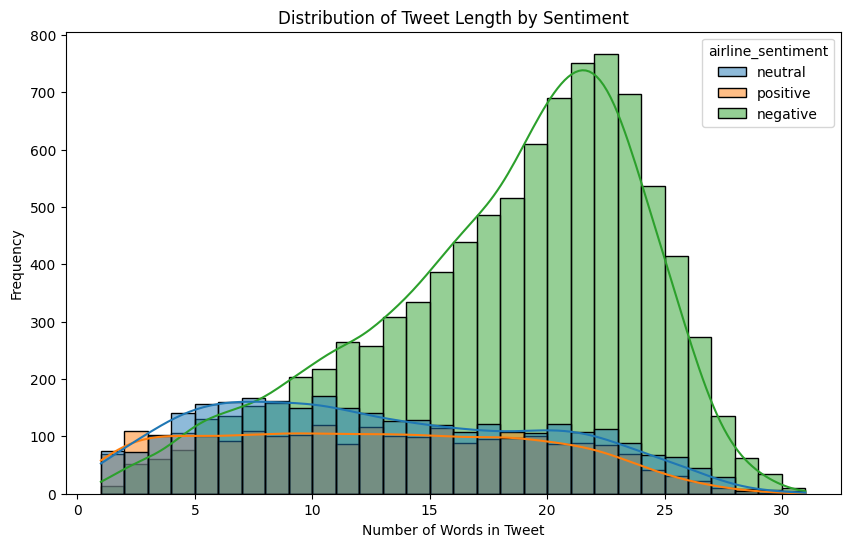

In [82]:
data['text_length'] = data['clean_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.histplot(data=data, x='text_length', hue='airline_sentiment', bins=30, kde=True)
plt.title("Distribution of Tweet Length by Sentiment")
plt.xlabel("Number of Words in Tweet")
plt.ylabel("Frequency")
plt.show()


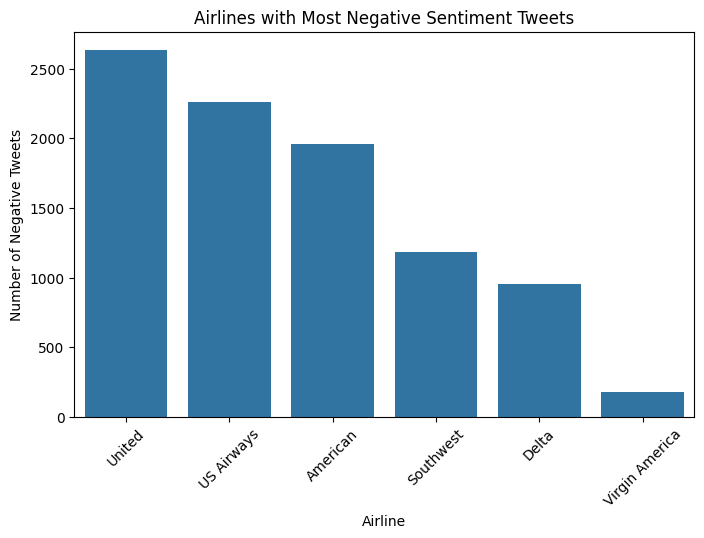

In [85]:
negatives = pd.read_csv("dataset/Tweets.csv")
negatives = negatives[negatives['airline_sentiment'] == 'negative']
airline_counts = negatives['airline'].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=airline_counts.index, y=airline_counts.values)
plt.title("Airlines with Most Negative Sentiment Tweets")
plt.ylabel("Number of Negative Tweets")
plt.xlabel("Airline")
plt.xticks(rotation=45)
plt.show()


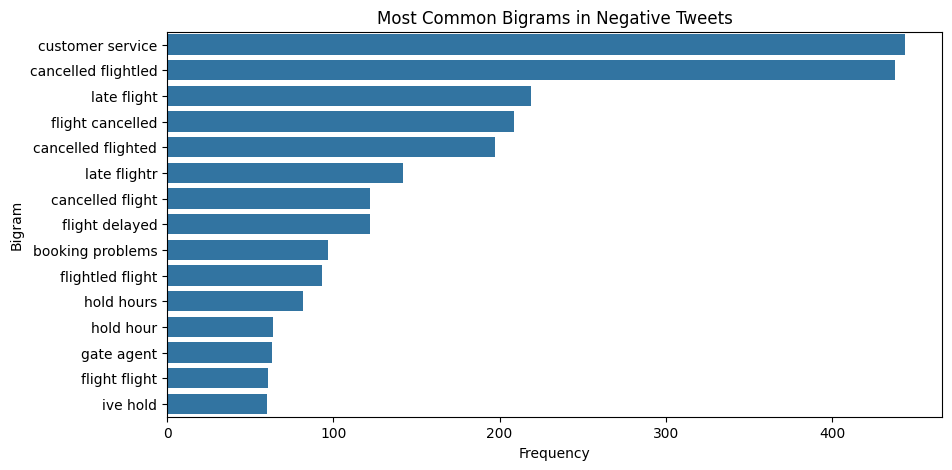

In [86]:
from sklearn.feature_extraction.text import CountVectorizer

neg_texts = data[data['label'] == 0]['clean_text']
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
X = vectorizer.fit_transform(neg_texts)
bigrams = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names_out()).T
bigrams.columns = ['frequency']
bigrams = bigrams.sort_values(by='frequency', ascending=False).head(15)

# Plot top bigrams
plt.figure(figsize=(10,5))
sns.barplot(x='frequency', y=bigrams.index, data=bigrams)
plt.title("Most Common Bigrams in Negative Tweets")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.show()
